In [390]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import norm

# Goals

The main goal is to find the car that is the best investment in the long-run. The goal is to keep the car for 10 years. So, I want to find the car that is the cheapest.

## Problems With the Analysis 

This analysis does not take the following into consideration:

- Insurance expenses which _will_ be dependent on the car purchased.
- Interest via a car loan. The analysis assumes the car is purchased out-right, given my current car lasts until I have the money to do so.
- Car registration fees.
- Analysis does not cover maintenance fees or potential reliability issues that may arise.

## Data Topology

The input data is split among different car trims. The data includes the following columns:

- *Brand*: The brand of the car.
- *Model*: The model of the car.
- *Year*: The year of the car.
- *Trim*: The trim of a car model. Not all trims may be listed.
- *MSRP*: The base price for a car trim.
- *City Range*: The number of miles a car receives within the city on one tank of gas.
- *Highway Range*: The number of miles a car receives on the highway on one tank of gas.
- *Tank Size*: The size (in gallons) of the car.

The following code initializes the data for analytical treatment.

In [391]:
# data source: www.edmunds.com
df = pd.read_excel('data.xlsx')
df

,Brand,Model,Year,Trim,MSRP,City Range,Highway Range,Tank Size
0,Toyota,Corolla,2024,LE,22050,422.4,541.2,13.2
1,Honda,Civic,2024,LX,23950,384.4,496.0,12.4
2,Volkswagen,Jetta,2024,S,21435,382.8,554.4,13.2
3,Mazda,3,2024,S,25690,356.4,462.0,13.2
4,Toyota,Prius,2024,LE,27950,644.1,632.8,11.3
5,Toyota,Prius Prime,2024,LE,32975,561.8,540.6,10.6
6,Toyota,Corolla Hybrid,2024,LE,23500,598.9,519.8,11.3
7,Subaru,Impreza,2024,Base,22995,448.2,564.4,16.6
8,Subaru,Legacy,2024,Base,24895,499.6,647.5,18.5
9,Mitsubishi,Mirage,2024,ES,16695,331.2,395.6,9.2


## Gas Cost Analysis

To get an understanding of how fuel efficient a car is (on the wallet), the gallons per mile ($GPM$)  is needed. The GPM is calculated as the tank size over the given range (either city or highway). The lower the $GPM$, the more efficient the car. GPM is utilized for convenience to find the cumulative gallons ($CG$) consumed after $d$  miles is driven, provided the following formula. 

$$CG = GPM \cdot d.$$

Using the cumulative gas, the cost for fuel given the miles driven of a car and the average cost of gas $\mu_g$ and the following formula.

$$c_{Fuel} = CG \cdot \mu_g.$$

Or more completely, the cost of driving $d$ miles is the following.

$$c_{Fuel}(d) = \mu_g \cdot GPM \cdot d$$

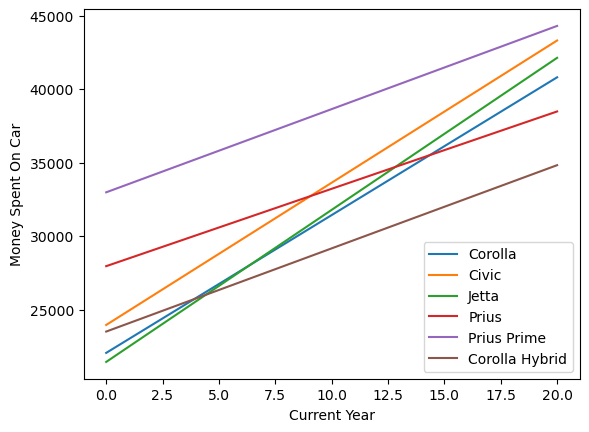

In [414]:
# compare miles driven to the amount of gallons filled in the tank
# adjustable...
rangeLabel = "City Range"
gasCost = 3
milesPerYear = 10000 # m/y
distanceTraveled = 200000

df.loc[:, "Gal/Mile"] = df.loc[:, "Tank Size"] / df.loc[:, rangeLabel]

# Fix cost generation
def linearGasForm(row, gasCost):
    milage = np.arange(0, distanceTraveled, 1)
    gallonsConsumed = row["Gal/Mile"] * milage
    moneySpent = gallonsConsumed * gasCost
    return (True, moneySpent) # boolean signifies that this should be calculated for each model

def plotCost(gasCost, gasFormula=linearGasForm, models=df.loc[:, "Model"]):
    legend = np.array([])
    gasMoney = (True, 0)
    for index, row in df.iterrows():
        if row["Model"] in models: # needed to properly see some of these lines...
            milage = np.arange(0, distanceTraveled, 1)
            gasMoney = gasFormula(row, gasCost) if gasMoney[0] else gasMoney
            moneySpentOnCar = gasMoney[1] + row["MSRP"]
            year = milage / milesPerYear
            plt.plot(year, moneySpentOnCar)
            legend = np.append(legend, row["Model"]) # Make sure the legend is correctly ordered.

    plt.legend(legend)
    plt.xlabel("Current Year")
    plt.ylabel("Money Spent On Car")
    plt.show()
    
plotCost(gasCost, models=["Corolla", "Corolla Hybrid", "Prius", "Prius Prime", "Civic", "Jetta"])

The above figure is found by calculating the gallons used per mile in a car. Then, the gallons used after a given number of miles can be computed as `gallonsFilled`. From this quantity, the money spent on gas for a given car after a certain number of miles is `moneyOnGas`. Adding the `moneyOnGas` with the MSRP of the car gives the total amount of money spent on a car after a given amount of _miles driven_. This can be converted to a cumulative cost per year by providing a projected number of miles driven per year (shown using $10,000$ miles per year).

To try and analyze a more "realistic" scenario, the gas price will be found using a Normal distribution where $\mu$ is the previous gas price and $\sigma=0.02$. A low standard deviation is utilized, as a new gas price is calculated _per mile_ (for now). 

Accumulate: [   39.7409068     39.7409068     39.7409068  ... 22745.63258643
 22745.63258643 22745.63258643]
Accumulate: [   37.33236699    37.33236699    37.33236699 ... 23429.67321238
 23429.67321238 23429.67321238]
Accumulate: [   34.02062476    34.02062476    34.02062476 ... 12771.94465058
 12771.94465058 12771.94465058]
Accumulate: [   31.91315243    31.91315243    31.91315243 ... 13745.60019241
 13745.60019241 13745.60019241]
Accumulate: [   34.02062476    34.02062476    34.02062476 ... 13722.72234488
 13722.72234488 13722.72234488]


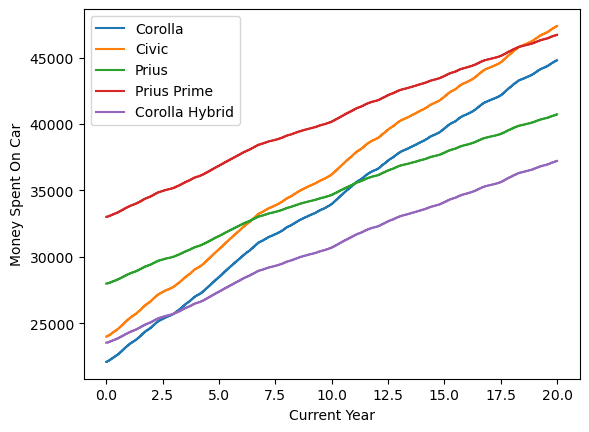

In [415]:
# stdev
stdev = 0.02

# clamp a value by the previous value and an error bound. For example clamp(3, 2) would return 
def clamp(val, prev, bound):
    if val > prev + bound: # return upper clamp when val is greater than upper bound.
        return prev + bound
    if val < prev - bound: # return lower clamp when val is lower than lower bound.
        return prev - bound
    return val

def getGasPrices(domain, mean, stdev, gMin=1.50, gMax=4.00):
    prices = np.array([])
    errorBound = stdev * 15
    
    for i in domain:
        avg = mean if i == 0 else prices[i-1]
        randomPrice = norm.rvs(loc=avg, scale=stdev)
        while randomPrice < gMin or randomPrice > gMax: # to prevent un-realistic gas prices (assuming regular 87 gas prices)
            randomPrice = norm.rvs(loc=avg, scale=stdev)
        nextPrice = clamp(randomPrice, avg, errorBound) 
        prices = np.append(prices, nextPrice)
        
    return prices

def accumulateGasForm(row, gasCost):
    accumulation = np.array([])
    
    for t in range(len(gasCost)):
        localAccumulation = gasCost[0] if t == 0 else accumulation[t - 1] + gasCost[t]
        accumulation = np.append(accumulation, localAccumulation)
    
    accumulation = accumulation * row["Gal/Mile"]  
    print(f"Accumulation: {accumulation}")
    return (False, accumulation)

# assumes an empty tank when the car is purchased.
"""
Rules for when to pump gas:
1. Gas pumping occurs when there is a quarter of the fuel left (so quarter range left).
2. 
"""
def simulatedGasPump(row, gasCost, fuelAtTankLevel=0.25):
    totalGasCost = 0
    rangeType = 'City Range'
    accumulate = np.array([])
    lastPump = int(-1 * (1 - fuelAtTankLevel) * int(row[rangeType])) # makes the range floating point negligible
    
    for t in range(len(gasCost)):
        if t - lastPump == int((1-fuelAtTankLevel) * int(row[rangeType])): # fuel up at a given tank level
            totalGasCost = totalGasCost + gasCost[t] * row[rangeType] * row['Gal/Mile']
            lastPump = t
        accumulate = np.append(accumulate, totalGasCost)
    
    print(f'Accumulate: {accumulate}') 
    return (True, accumulate)

# now, I could develop a simulation for gas pumping.
# When the range has been reached, we fill at the current gas cost for 'd' = range.

dom = np.arange(0, distanceTraveled, 1)
prices = getGasPrices(dom, 3, stdev)
plotCost(prices, gasFormula=simulatedGasPump, models=["Corolla", "Corolla Hybrid", "Prius", "Prius Prime", "Civic"])